In [80]:
!export TF_ENABLE_ONEDNN_OPTS=0

In [81]:
import ccxt
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd

from datetime import datetime, timedelta
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [82]:
# Create an instance of the exchange
exchange = ccxt.binance()

# Fetch OHLCV (Open, High, Low, Close, Volume) data for BTC/EUR pair
ohlcv = exchange.fetch_ohlcv('BTC/EUR', timeframe='1d')

In [83]:
df_ohlcv = pd.DataFrame(ohlcv, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

In [85]:
df_ohlcv['date'] = df_ohlcv['date'].apply(lambda x: datetime.fromtimestamp(x/1000))

In [86]:
df_ohlcv.head()

,date,open,high,low,close,volume
0,2022-08-10 02:00:00,22712.40,23551.12,22246.88,23287.96,2622.66664
1,2022-08-11 02:00:00,23291.14,24125.00,23151.70,23241.01,2716.45139
2,2022-08-12 02:00:00,23244.14,23849.00,22960.00,23789.39,1995.42382
3,2022-08-13 02:00:00,23794.16,24235.37,23666.00,23848.48,1634.92142
4,2022-08-14 02:00:00,23851.03,24400.00,23582.04,23733.76,1578.95074


In [87]:
df_ohlcv.describe()

,date,open,high,low,close,volume
count,500,500.00000,500.000000,500.000000,500.000000,500.000000
mean,2023-04-16 13:35:52.799999744,24201.50284,24624.668800,23818.927500,24234.797400,1671.702332
min,2022-08-10 02:00:00,15387.42000,15487.350000,15120.000000,15379.210000,88.261530
25%,2022-12-12 19:00:00,20202.55000,20555.290000,19775.677500,20204.750000,507.784427
50%,2023-04-16 14:00:00,24386.73500,24760.705000,24010.865000,24417.795000,1100.734155
75%,2023-08-19 08:00:00,26740.46750,27056.987500,26496.265000,26762.137500,2407.900492
max,2023-12-22 01:00:00,41123.35000,41574.460000,40561.590000,41109.830000,11341.142750
std,NaN,5562.71820,5676.448248,5474.017093,5603.934873,1605.430951


In [88]:
# Filter the DataFrame to start at the specific date
df_ohlcv_year = df_ohlcv[df_ohlcv['date'] >= df_ohlcv['date'].max() - timedelta(days=365)]

In [89]:
df_ohlcv_year.describe()

,date,open,high,low,close,volume
count,366,366.000000,366.000000,366.000000,366.000000,366.000000
mean,2023-06-22 13:35:34.426229248,26058.207377,26513.550273,25669.907705,26122.401421,1227.024067
min,2022-12-22 01:00:00,15425.080000,15487.350000,15306.590000,15425.260000,88.261530
25%,2023-03-23 07:00:00,24034.455000,24278.140000,23567.875000,24053.192500,426.185962
50%,2023-06-22 14:00:00,25635.005000,26043.990000,25207.945000,25671.700000,769.604180
75%,2023-09-21 20:00:00,27371.725000,27895.640000,27108.385000,27471.422500,1413.951097
max,2023-12-22 01:00:00,41123.350000,41574.460000,40561.590000,41109.830000,7990.789180
std,NaN,5242.051452,5354.479659,5127.697546,5261.412217,1300.229773


In [90]:
df_year = df_ohlcv_year['open'].values

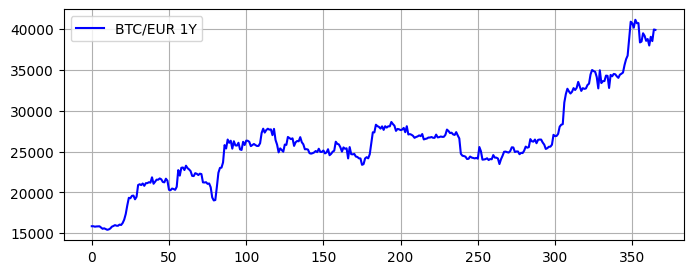

In [92]:
plt.figure(figsize=(8,3))
plt.plot(df, color='blue', label='BTC/EUR 1Y')
plt.grid()
plt.legend();

In [95]:
df = df_ohlcv['open'].values
df = df.reshape(-1, 1)

In [100]:
# test train split
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])

In [101]:
# scaling data
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

In [104]:
def create_custom_dataset(df):
    x = []
    y = []
    for i in range(50,df.shape[0]):
        x.append(df[i-50:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [107]:
x_train, y_train = create_custom_dataset(dataset_train)
x_test, y_test = create_custom_dataset(dataset_test)

In [108]:
# reshaping for LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)
print(x_test.shape)

(350, 50, 1)
(100, 50, 1)


In [109]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2023-12-22 00:48:56.436618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-22 00:48:56.437091: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [110]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 96)                74112     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

In [111]:
model.compile(loss='mean_squared_error', optimizer ='adam')

In [112]:
if not os.path.exists('models/bitcoin_eur_prediction.keras'):
    model.fit(x_train, y_train, epochs=50, batch_size=32)
    model.save('models/bitcoin_eur_prediction.keras')

Epoch 1/50
11/11 [==============================] - 4s 58ms/step - loss: 0.1034
Epoch 2/50
11/11 [==============================] - 1s 56ms/step - loss: 0.0270
Epoch 3/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0189
Epoch 4/50
11/11 [==============================] - 1s 56ms/step - loss: 0.0161
Epoch 5/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0150
Epoch 6/50
11/11 [==============================] - 1s 55ms/step - loss: 0.0148
Epoch 7/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0131
Epoch 8/50
11/11 [==============================] - 1s 56ms/step - loss: 0.0122
Epoch 9/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0124
Epoch 10/50
11/11 [==============================] - 1s 53ms/step - loss: 0.0132
Epoch 11/50
11/11 [==============================] - 1s 53ms/step - loss: 0.0137
Epoch 12/50
11/11 [==============================] - 1s 54ms/step - loss: 0.0117
Epoch 13/50
11/11 [==================

In [113]:
model = load_model('models/bitcoin_eur_prediction.keras')

4/4 [==============================] - 0s 17ms/step


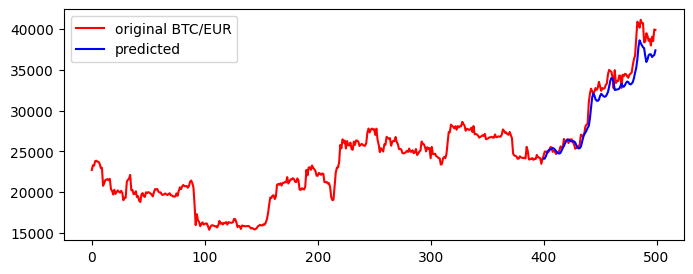

In [136]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # inverse MinMaxScaler()

fig, ax = plt.subplots(figsize=(8,3))
plt.plot(df, color='red', label='original BTC/EUR')
ax.plot(range(len(y_train)+50, len(y_train)+50+len(predictions)),predictions,color='blue', label='predicted')
plt.legend()

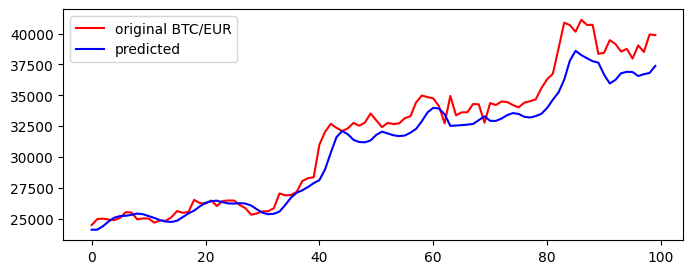

In [120]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(y_test_scaled, color='red', label = 'original BTC/EUR')
plt.plot(predictions, color = 'blue', label='predicted')
plt.legend()